# Importando Bibliotecas

In [1]:
# Importando as bibliotecas necessárias
import os
from pathlib import Path
import pandas as pd
import dill
import glob
import numpy as np
import torch

# Visualizando a distribuição dos valores pagos em sinistros
import matplotlib.pyplot as plt


from darts.dataprocessing.transformers import MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood

import optuna
print(f'optuna: {optuna.__version__}')
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances, plot_contour

import darts
print(f'darts: {darts.__version__}')
from darts.metrics import mse,rmse,rmsle,mae,mape,smape,qr,ql,ope
from darts.models import RNNModel


import pytorch_lightning as pl
print(f'pytorch_lightning: {pl.__version__}')  # Mostra a versão diretamente



import optuna

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings

class PyTorchLightningPruningCallback(Callback):
    """PyTorch Lightning callback to prune unpromising trials.
    See `the example <https://github.com/optuna/optuna-examples/blob/
    main/pytorch/pytorch_lightning_simple.py>`__
    if you want to add a pruning callback which observes accuracy.
    Args:
        trial:
            A :class:`~optuna.trial.Trial` corresponding to the current evaluation of the
            objective function.
        monitor:
            An evaluation metric for pruning, e.g., ``val_loss`` or
            ``val_acc``. The metrics are obtained from the returned dictionaries from e.g.
            ``pytorch_lightning.LightningModule.training_step`` or
            ``pytorch_lightning.LightningModule.validation_epoch_end`` and the names thus depend on
            how this dictionary is formatted.
    """

    def __init__(self, trial: optuna.trial.Trial, monitor: str) -> None:
        super().__init__()

        self._trial = trial
        self.monitor = monitor

    def on_validation_end(self, trainer: Trainer, pl_module: LightningModule) -> None:
        # When the trainer calls `on_validation_end` for sanity check,
        # do not call `trial.report` to avoid calling `trial.report` multiple times
        # at epoch 0. The related page is
        # https://github.com/PyTorchLightning/pytorch-lightning/issues/1391.
        if trainer.sanity_checking:
            return

        epoch = pl_module.current_epoch

        current_score = trainer.callback_metrics.get(self.monitor)
        if current_score is None:
            message = (
                "The metric '{}' is not in the evaluation logs for pruning. "
                "Please make sure you set the correct metric name.".format(self.monitor)
            )
            warnings.warn(message)
            return

        self._trial.report(current_score, step=epoch)
        if self._trial.should_prune():
            message = "Trial was pruned at epoch {}.".format(epoch)
            raise optuna.TrialPruned(message)


optuna: 3.6.1
darts: 0.30.0
pytorch_lightning: 2.3.3


# Extrai os dados tratados

**Descrição das Colunas:**

1. **D_OCORR** (Data da Ocorrência): Data em que ocorreu o sinistro, usada para organizar e agrupar os registros no tempo.
   
2. **INDENIZ** (Valor da Indenização): Valor pago pela seguradora para cobrir o sinistro. Essa é a variável-alvo do modelo, ou seja, o que queremos prever.

3. **MODALIDADE**: Tipo de modalidade de seguro contratada. Representada por várias subcategorias após o One-Hot Encoding.

4. **TIPO_PROD**: Tipo de produto de seguro. Representado por subcategorias após o One-Hot Encoding.

5. **SEXO**: Gênero do segurado (Masculino ou Feminino). Representado por subcategorias (SEXO_F e SEXO_M) após o One-Hot Encoding.

6. **REGIAO**: Região geográfica onde o segurado está localizado. Representado por subcategorias após o One-Hot Encoding com base nos códigos oficiais dos estados brasileiros.

7. **VAL_SALVAD** (Valor Salvado): Valor residual recuperado após o sinistro, geralmente relacionado ao que restou do veículo. Usado como uma variável contínua nas previsões.

8. **VAL_RESS** (Valor Residual): Valor residual relacionado à apólice, referente a deduções aplicadas após o sinistro. Também usada como uma variável contínua.

9. **EVENTO** Refere-se ao tipo de evento relacionado ao sinistro, podendo variar entre diferentes causas, como roubo, colisão, incêndio, etc. A codificação varia de 1 a 9, representando diferentes tipos de eventos.

10. **CAUSA**: Indica a causa específica do sinistro, com códigos que variam de 1 a 8. Cada código representa uma causa distinta, como falha mecânica, erro do motorista, causas naturais, entre outras.

**Covariáveis:**

- **Covariáveis Passadas**: Todas as variáveis categóricas e contínuas, exceto a coluna de data (`D_OCORR`) e o alvo (`INDENIZ`). Essas covariáveis incluem:
   - **MODALIDADE** (subcategorias)
   - **TIPO_PROD** (subcategorias)
   - **SEXO** (subcategorias)
   - **REGIAO** (subcategorias)
   - **VAL_SALVAD** e **VAL_RESS** (variáveis contínuas)

- **Covariáveis Futuras**: O atributo **D_OCORR** será usado para capturar padrões temporais ao longo do tempo.

**Variável-Alvo:**
**INDENIZ** (Valor da Indenização): O valor a ser previsto com base nas covariáveis categóricas e contínuas fornecidas.



In [2]:
path_project = "../"
# print(f'Projeto salvo em: {full_path}')

path_raw = "../data/raw"
path_processed = "../data/processed"
file_path = os.path.join(path_processed,'trated_data.csv')
df = pd.read_csv(file_path, sep=';')
df.head()

,D_OCORR,INDENIZ,EVENTO_1,EVENTO_2,EVENTO_3,EVENTO_4,EVENTO_5,EVENTO_6,EVENTO_7,EVENTO_8,CAUSA_1,CAUSA_2,CAUSA_3,CAUSA_4,CAUSA_5,CAUSA_6,CAUSA_7,MODALIDADE_1,MODALIDADE_2,MODALIDADE_3,TIPO_PROD_1,TIPO_PROD_2,REGIAO_11.0,REGIAO_12.0,REGIAO_13.0,REGIAO_14.0,REGIAO_15.0,REGIAO_16.0,REGIAO_17.0,REGIAO_21.0,REGIAO_22.0,REGIAO_23.0,REGIAO_24.0,REGIAO_25.0,REGIAO_26.0,REGIAO_27.0,REGIAO_28.0,REGIAO_29.0,REGIAO_31.0,REGIAO_32.0,REGIAO_33.0,REGIAO_35.0,REGIAO_41.0,REGIAO_42.0,REGIAO_43.0,REGIAO_50.0,REGIAO_51.0,REGIAO_52.0,REGIAO_53.0,SEXO_F,SEXO_M,VAL_SALVAD,VAL_RESS
0,1970-01-01,6477.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.262622,0.0,0.737378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1981-03-05,3742.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1988-11-19,187500.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1992-01-19,1400.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1993-08-11,80413.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Série Temporal Darts

Transforma dados de indenizações em um gráfico de linha mostrando os valores diários de 2015 a 2019.  

**Passo a passo:**  
1. Converte a tabela de dados para formato de série temporal (com datas diárias)  
2. Completa datas e valores faltantes automaticamente  
3. Filtra apenas o período de 2015-2019  
4. Gera e salva o gráfico (`indenizacao_2015_2019.png`)  

**Saída:**  
Um gráfico pronto para análise, mostrando como as indenizações variaram dia após dia nesses 5 anos.  

In [3]:
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller

# Criar a série TimeSeries
df_series_all = TimeSeries.from_dataframe(
    df,
    # value_cols='INDENIZ',  # Coluna alvo
    time_col='D_OCORR',
    fill_missing_dates=True,  # Preencher datas ausentes
    freq='D'  # Frequência diária
)


# Preencher valores faltantes
df_series_all = MissingValuesFiller().transform(df_series_all)

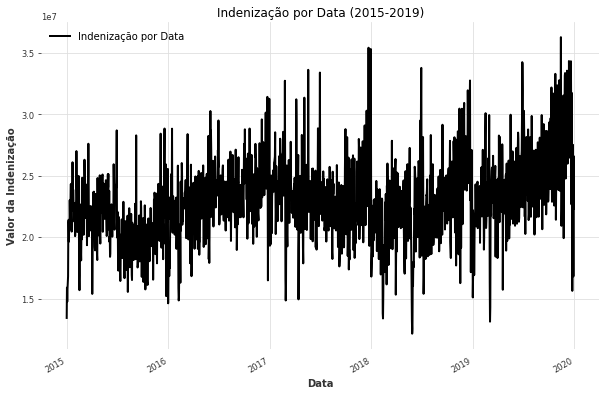

In [4]:
# Filtrar a série para os anos de 2010 a 2019 usando o método slice
df_series = df_series_all.slice(pd.Timestamp('2015-01-01'), pd.Timestamp('2019-12-31'))

# Plotar a indenização nesse período
plt.figure(figsize=(10, 6))
df_series['INDENIZ'].plot(label='Indenização por Data')

# Adicionar título e rótulos
plt.title('Indenização por Data (2015-2019)')
plt.xlabel('Data')
plt.ylabel('Valor da Indenização')

# Exibir o gráfico
plt.savefig(os.path.join(path_project,'reports','figures','indenizacao_2015_2019.png'))
plt.show()


# Divisão dos Dados

**Preparação de Dados para Modelo de Previsão Temporal**

**Objetivo:**  
Estruturar os dados de forma adequada para treinamento, validação e teste de modelos de séries temporais.

**Fluxo de Divisão dos Dados:**

1. **Divisão Inicial**
   - 85% dos dados iniciais → Treino + Validação
   - 15% dos dados finais → Teste + Calibração

2. **Subdivisão do Conjunto de Treino**
   - 70% → Dados de Treino efetivos
   - 30% → Dados de Validação

3. **Divisão do Conjunto de Teste**
   - 50% → Calibração do modelo
   - 50% → Teste final

**Processamento de Variáveis:**

1. **Covariáveis Temporais**
   - Passadas: Utiliza outras colunas além do alvo e data
   - Futuras: Incorpora informação do dia da semana em formato one-hot encoding

2. **Normalização**
   - Aplica Scaler para padronização das variáveis numéricas
   - Garante que todas as features estejam na mesma escala

**Saídas Geradas:**

- Conjuntos estruturados:
  - Treino (70%)
  - Validação (15%)
  - Calibração (7.5%)
  - Teste final (7.5%)

- Visualização:
  - Gráfico da série temporal normalizada (`train_indenizacao_scaled.png`)

**Importância do Processo:**

1. **Validação Robusta**
   - Separação clara entre dados de treino e teste
   - Conjunto dedicado para calibração

2. **Qualidade dos Dados**
   - Normalização adequada das variáveis
   - Incorporação de informações temporais relevantes

3. **Reprodutibilidade**
   - Estrutura padronizada para experimentos futuros
   - Divisão temporal que preserva a ordem dos eventos) para melhorar as previsões

In [5]:
# Define as proporções de divisão dos dados
train_val_size = int(0.85 * len(df_series))  # 85% para treino_geral (treino + validação)
test_size = len(df_series) - train_val_size  # 15% para teste (que será dividido em calibração e teste)

# 1. Divide em treino_geral (treino + validação) e teste (que será usado depois para calibração e teste final)
treino_geral_series, test_series = df_series.split_after(train_val_size)

# 2. Divide treino_geral em treino e validação
train_size = int(0.7 * len(treino_geral_series))  # 70% do treino_geral para treino real
train_series, val_series = treino_geral_series.split_after(train_size)

# Define a proporção para calibração e teste final
cal_size = int(0.5 * len(test_series))  # 50% para calibração e 50% para teste final

# 3. Divide test_series em calibração e teste final
cal_series, test_final_series = test_series.split_after(cal_size)

# Exibir as dimensões das séries divididas
print(f"Treino Series - Timesteps: {train_series.n_timesteps}, Components: {train_series.n_components}")
print(f"Validação Series - Timesteps: {val_series.n_timesteps}, Components: {val_series.n_components}")
print(f"Calibração Series - Timesteps: {cal_series.n_timesteps}, Components: {cal_series.n_components}")
print(f"Teste Final Series - Timesteps: {test_final_series.n_timesteps}, Components: {test_final_series.n_components}")



Treino Series - Timesteps: 1088, Components: 52
Validação Series - Timesteps: 465, Components: 52
Calibração Series - Timesteps: 137, Components: 52
Teste Final Series - Timesteps: 136, Components: 52


**Covariáveis Passadas**

In [6]:
# Seleciona as colunas para as covariáveis passadas, removendo a coluna de tempo e o alvo
past_covariates_columns = df.drop(columns=['INDENIZ', 'D_OCORR']).columns.tolist()

# Cria as covariáveis passadas para o treino
train_past_covariates = train_series[past_covariates_columns]
train_past_covariates = MissingValuesFiller().transform(train_past_covariates)

# Cria as covariáveis passadas para a validação
val_past_covariates = val_series[past_covariates_columns]
val_past_covariates = MissingValuesFiller().transform(val_past_covariates)

# Exibe as dimensões das covariáveis passadas
print(f"Train Past Covariates - Timesteps: {train_past_covariates.n_timesteps}, Components: {train_past_covariates.n_components}")
print(f"Validation Past Covariates - Timesteps: {val_past_covariates.n_timesteps}, Components: {val_past_covariates.n_components}")


Train Past Covariates - Timesteps: 1088, Components: 51
Validation Past Covariates - Timesteps: 465, Components: 51


**Covariáveis Futuras**

In [7]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# Cria as covariáveis futuras (day_series) para o treino e validação a partir de 'D_OCORR'
train_future_covariates = datetime_attribute_timeseries(
    train_series.time_index,
    attribute="day",  # Aqui estamos pegando a informação do "dia"
    one_hot=True,
    dtype=np.float32
)

val_future_covariates = datetime_attribute_timeseries(
    val_series.time_index,
    attribute="day",
    one_hot=True,
    dtype=np.float32
)

# Exibe as dimensões das covariáveis futuras
print(f"Train Future Covariates - Timesteps: {train_future_covariates.n_timesteps}, Components: {train_future_covariates.n_components}")
print(f"Validation Future Covariates - Timesteps: {val_future_covariates.n_timesteps}, Components: {val_future_covariates.n_components}")


Train Future Covariates - Timesteps: 1088, Components: 31
Validation Future Covariates - Timesteps: 465, Components: 31


**Normalizando os dados de treinamento**

In [8]:
from darts.dataprocessing.transformers import Scaler

# Seleciona as colunas contínuas que precisam de normalização
continuous_columns = ['INDENIZ', 'VAL_SALVAD', 'VAL_RESS']

# Cria um scaler para as variáveis contínuas
scaler = Scaler()

# Aplica o scaler nas colunas contínuas da série de treino
train_continuous_scaled = scaler.fit_transform(train_series[continuous_columns])

# Aplica o scaler treinado nos dados de validação, calibração e teste
val_continuous_scaled = scaler.transform(val_series[continuous_columns])
cal_continuous_scaled = scaler.transform(cal_series[continuous_columns])
test_continuous_scaled = scaler.transform(test_final_series[continuous_columns])

# Exibe as dimensões após a normalização
print(f"Train Series (Scaled) - Timesteps: {train_continuous_scaled.n_timesteps}, Components: {train_continuous_scaled.n_components}")
print(f"Validation Series (Scaled) - Timesteps: {val_continuous_scaled.n_timesteps}, Components: {val_continuous_scaled.n_components}")
print(f"Calibration Series (Scaled) - Timesteps: {cal_continuous_scaled.n_timesteps}, Components: {cal_continuous_scaled.n_components}")
print(f"Test Final Series (Scaled) - Timesteps: {test_continuous_scaled.n_timesteps}, Components: {test_continuous_scaled.n_components}")


Train Series (Scaled) - Timesteps: 1088, Components: 3
Validation Series (Scaled) - Timesteps: 465, Components: 3
Calibration Series (Scaled) - Timesteps: 137, Components: 3
Test Final Series (Scaled) - Timesteps: 136, Components: 3


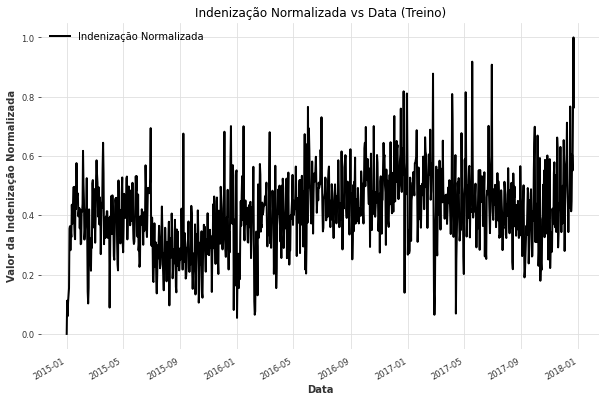

In [9]:
# Selecionar a série normalizada da indenização
train_indenizacao_scaled = train_continuous_scaled['INDENIZ']

# Plotar a indenização normalizada no treino
plt.figure(figsize=(10, 6))
train_indenizacao_scaled.plot(label='Indenização Normalizada')

# Adicionar título e rótulos
plt.title('Indenização Normalizada vs Data (Treino)')
plt.xlabel('Data')
plt.ylabel('Valor da Indenização Normalizada')

# Exibir o gráfico
plt.savefig(os.path.join(path_project,'reports','figures','train_indenizacao_scaled.png'))
plt.show()


# Construção da Rede Neural LSTM

Prepara e otimiza um modelo LSTM para previsão de séries temporais univariadas (valores de indenização).

**Principais etapas:**

1. **Pré-processamento:**
   - Seleciona apenas a coluna 'INDENIZ'
   - Normaliza os dados usando Scaler
   - Cria covariáveis futuras (informação de dia da semana)

2. **Configuração do Modelo:**
   - Define funções para ajustar automaticamente os parâmetros de treino
   - Implementa um modelo LSTM com:
     - Early stopping
     - Checkpointing
     - Suporte a covariáveis

3. **Otimização com Optuna:**
   - Testa combinações de hiperparâmetros (25 trials)
   - Usa poda inteligente (pruning) para eficiência
   - Armazena resultados em banco de dados SQLite

4. **Resultados:**
   - Identifica os melhores parâmetros
   - Salva o estudo completo para análise futura

**Saídas importantes:**
- Modelo LSTM otimizado
- Gráficos de desempenho
- Arquivo com estudo completo (optuna_study.pkl)
- Melhores parâmetros encontrados

**Configurações-chave:**
- Janela de entrada: 24 passos
- Janela de treino: 365 dias
- Paciência: 25 épocas
- Faixa de neurônios: 50-300

**Preparação e Escalonamento das Séries Temporais Univariadas (INDENIZ)**

In [10]:
from darts.dataprocessing.transformers import Scaler

# Seleciona apenas a coluna 'INDENIZ' das séries de treino, validação, calibração e teste
train_series_univariate = train_series['INDENIZ']
val_series_univariate = val_series['INDENIZ']
cal_series_univariate = cal_series['INDENIZ']
test_final_series_univariate = test_final_series['INDENIZ']

# Cria um scaler para a variável 'INDENIZ'
scaler = Scaler()

# Aplica o scaler na série de treino
train_continuous_scaled = scaler.fit_transform(train_series_univariate)

# Aplica o scaler treinado nos dados de validação, calibração e teste
val_continuous_scaled = scaler.transform(val_series_univariate)
cal_continuous_scaled = scaler.transform(cal_series_univariate)
test_continuous_scaled = scaler.transform(test_final_series_univariate)

# Exibe as dimensões após a normalização
print(f"Train Series (Scaled) - Timesteps: {train_continuous_scaled.n_timesteps}, Components: {train_continuous_scaled.n_components}")
print(f"Validation Series (Scaled) - Timesteps: {val_continuous_scaled.n_timesteps}, Components: {val_continuous_scaled.n_components}")
print(f"Calibration Series (Scaled) - Timesteps: {cal_continuous_scaled.n_timesteps}, Components: {cal_continuous_scaled.n_components}")
print(f"Test Final Series (Scaled) - Timesteps: {test_continuous_scaled.n_timesteps}, Components: {test_continuous_scaled.n_components}")


Train Series (Scaled) - Timesteps: 1088, Components: 1
Validation Series (Scaled) - Timesteps: 465, Components: 1
Calibration Series (Scaled) - Timesteps: 137, Components: 1
Test Final Series (Scaled) - Timesteps: 136, Components: 1


In [11]:
# Cria as covariáveis futuras (calendário, etc.)
all_future_covariates = datetime_attribute_timeseries(
    df_series.time_index,
    attribute="day",
    one_hot=True,
    dtype=np.float32
)

**Gerenciamento Dinâmico de Janelas de Treinamento e Validação**

In [12]:
# Função para ajustar os tamanhos do bloco e do input
def adjust_block_and_input_sizes(total_days, desired_block_size, desired_input_size, output_chunk_length=1):
    # Certifique-se de que haja dados suficientes para pelo menos um ponto de treinamento
    min_length = desired_block_size + output_chunk_length
    if total_days < min_length:
        block_size = max(1, total_days - output_chunk_length)
        input_size = max(1, block_size - output_chunk_length)
    else:
        block_size = min(desired_block_size, total_days)
        input_size = min(desired_input_size, total_days - output_chunk_length)  # Ensure at least 1 day for input
    return block_size, input_size

def verify_and_adjust_parameters(train_block_size, train_input_size, output_chunk_length, val_series_len, trial_parameters, message=False):
    min_val_length = train_block_size + output_chunk_length
    if val_series_len < min_val_length:
        if message:
            print(f"Conjunto de validação muito pequeno ({val_series_len} dias). Ajustando parâmetros...")
        val_block_size = max(1, val_series_len - output_chunk_length)
        val_input_size = max(1, val_block_size)
        trial_parameters['training_length'] = val_block_size
        trial_parameters['input_chunk_length'] = val_input_size
    else:
        trial_parameters['training_length'] = train_block_size
        trial_parameters['input_chunk_length'] = train_input_size
    return trial_parameters

def calculate_number_of_blocks(total_days, block_size):
    if block_size <= 0:
        return 0
    return total_days // block_size

def calculate_adjusted_parameters(train_series, val_series, desired_block_size, desired_input_size, output_chunk_length):
    # Ajustar os tamanhos para o conjunto de treino
    train_block_size, train_input_size = adjust_block_and_input_sizes(len(train_series), desired_block_size, desired_input_size, output_chunk_length)
    # Ajustar os tamanhos para o conjunto de validação
    val_block_size, val_input_size = adjust_block_and_input_sizes(len(val_series), desired_block_size, desired_input_size, output_chunk_length)

    # Atualizar os parâmetros com os valores ajustados
    adjusted_parameters = {
        'training_length': train_block_size,
        'input_chunk_length': train_input_size,
        'output_chunk_length': output_chunk_length
    }

    # Verificar e ajustar os parâmetros se necessário
    adjusted_parameters = verify_and_adjust_parameters(train_block_size, train_input_size, output_chunk_length, len(val_series), adjusted_parameters)

    return adjusted_parameters

# Exemplo de uso
adjusted_params = calculate_adjusted_parameters(train_series, val_series,
                                                desired_block_size=365,
                                                desired_input_size=24,
                                                output_chunk_length=1)
# Garantindo a relação lógica entre os parâmetros
max_input_chunk_length = adjusted_params['input_chunk_length']
max_training_length = adjusted_params['training_length']
max_output_chunk_length = adjusted_params['output_chunk_length']

# Imprimindo os resultados
print(min(24,max_input_chunk_length), max_input_chunk_length)
print(max_input_chunk_length, max_training_length)
print(max_output_chunk_length)

24 24
24 365
1


**Pipeline de Otimização de Hiperparâmetros para Modelo LSTM com Optuna**

In [13]:
def model_objective_lstm(train, val, trial_parameters, trial=None, **kwargs):
    """
    Treina um modelo LSTM para séries temporais com hiperparâmetros configuráveis.
    
    Suporta integração com Optuna (via parâmetro trial) e utiliza covariáveis futuras quando fornecidas.
    Configura automaticamente callbacks para early stopping e pruning (se trial for fornecido).
    
    Parâmetros:
    ----------
    train : TimeSeries
        Série temporal de treinamento
    val : TimeSeries
        Série temporal de validação
    trial_parameters : dict
        Dicionário com parâmetros do modelo (ex: hidden_dim, dropout, etc.)
    trial : optuna.Trial, optional
        Objeto trial do Optuna para habilitar pruning
    **kwargs : dict
        Argumentos extras (ex: train_future_covariates, val_future_covariates)
    
    Retorna:
    -------
    tuple
        (modelo_treinado, série de treino, série de validação)
    """

    # Configurar callbacks para pruning e early stopping
    # pruner = PyTorchLightningPruningCallback(trial, monitor="train_loss") if trial else None
    pruner = PyTorchLightningPruningCallback(trial, monitor="train_loss") if trial else None
    early_stopper = EarlyStopping(
        monitor="train_loss",
        min_delta=0.001,
        patience=trial_parameters.get('patience', 10),  # Padrão para 'patience'
        verbose=True
    )

    # Adicionar callback de checkpoint
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"../models/checkpoints/trial_{trial.number if trial else 'final'}",  # Pasta por trial
        filename="best_model-{epoch:02d}-{train_loss:.2f}",
        monitor="train_loss",
        mode="min",
        save_top_k=1,  # Salva apenas o melhor modelo
        save_weights_only=False  # Salva o modelo completo
    )

    callbacks = [early_stopper, checkpoint_callback] + ([pruner] if pruner else [])

    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": callbacks,
        "enable_progress_bar": kwargs.get("enable_progress_bar", True),
        "enable_checkpointing": True
    }

    # Criar o modelo LSTM com os parâmetros passados diretamente do dicionário trial_parameters
    model = RNNModel(
        model='LSTM',
        input_chunk_length=trial_parameters['input_chunk_length'],
        output_chunk_length=trial_parameters['output_chunk_length'],
        hidden_dim=trial_parameters['hidden_dim'],
        n_rnn_layers=trial_parameters['n_rnn_layers'],
        dropout=trial_parameters['dropout'],
        batch_size=trial_parameters['batch_size'],
        n_epochs=trial_parameters['n_epochs'],
        optimizer_kwargs={"lr": trial_parameters['lr']},
        random_state=trial_parameters['random_state'],
        likelihood=GaussianLikelihood(),
        pl_trainer_kwargs=pl_trainer_kwargs
    )

    # Obter as covariáveis futuras, se fornecidas
    train_future_covariates = kwargs.get('train_future_covariates', None)
    val_future_covariates = kwargs.get('val_future_covariates', None)

    # Treinar o modelo LSTM com covariáveis futuras, se aplicável
    model.fit(train, future_covariates=train_future_covariates)
    
    # Obter o caminho do melhor modelo salvo
    best_model_path = checkpoint_callback.best_model_path

    # Retornar o modelo treinado, treino e validação
    return model, train, val, best_model_path

def objective(trial, train, val, parameters, **kwargs):
    """
    Função objetivo para otimização de hiperparâmetros com Optuna.
    
    Gera sugestões de hiperparâmetros, treina o modelo LSTM e retorna o MSE
    calculado no conjunto de validação para guiar a otimização.
    
    Parâmetros:
    ----------
    trial : optuna.Trial
        Objeto trial do Optuna
    train : TimeSeries
        Série temporal de treinamento
    val : TimeSeries
        Série temporal de validação
    parameters : dict
        Dicionário com configurações de busca (tipos e bounds dos parâmetros)
    **kwargs : dict
        Argumentos extras (ex: covariáveis futuras)
    
    Retorna:
    -------
    float
        Valor do MSE calculado nas previsões de validação
    """
    print(f"Executando trial #{trial.number}")

    # Inicialização dos parâmetros ajustados
    trial_parameters = {}

    # Mapeia os tipos de sugestão do Optuna para cada parâmetro
    suggest_methods = {
        'int': trial.suggest_int,
        'float': trial.suggest_float,
        'categorical': trial.suggest_categorical
    }

    # Atualiza os parâmetros com os valores sugeridos pelo Optuna ou usa valores fixos
    for param, param_config in parameters.items():
        if isinstance(param_config, dict) and 'type' in param_config and 'bounds' in param_config:
            bounds = param_config['bounds']
            suggest_method = suggest_methods.get(param_config['type'])
            if suggest_method:
                if isinstance(bounds, tuple) and len(bounds) == 2:
                    trial_parameters[param] = suggest_method(param, *bounds)
                elif isinstance(bounds, list):
                    trial_parameters[param] = suggest_method(param, bounds)
        else:
            # Aqui estamos tratando parâmetros fixos
            trial_parameters[param] = param_config

    # Treinar o modelo LSTM
    model, train, val, best_model_path = model_objective_lstm(
        train=train,
        val=val,
        trial_parameters=trial_parameters,
        trial=trial,
        train_future_covariates=kwargs.get('train_future_covariates'),
        val_future_covariates=kwargs.get('val_future_covariates')
    )

    # Fazer previsões no conjunto de validação
    y_pred_val = model.predict(n=len(val), future_covariates=kwargs.get('val_future_covariates'))

    if y_pred_val is None:
        raise ValueError("O modelo não gerou previsões válidas")

    # Calcular a métrica MSE no conjunto de validação
    mse_val = mse(val, y_pred_val)

    return mse_val


def adjust_training_length(training_length, input_chunk_length):
    """
    Ajusta o training_length para garantir que seja pelo menos igual ao input_chunk_length.
    
    Parâmetros:
    ----------
    training_length : int
        Tamanho inicial proposto para a janela de treinamento
    input_chunk_length : int
        Tamanho do chunk de entrada requerido pelo modelo
    
    Retorna:
    -------
    int
        Valor ajustado de training_length (max(training_length, input_chunk_length))
    """
    if training_length < input_chunk_length:
        print(f"Ajustando training_length de {training_length} para {input_chunk_length}")
        return input_chunk_length
    return training_length

def update_optuna_parameters(optuna_parameters, best_params):
    """
    Atualiza os parâmetros originais com os melhores valores encontrados pelo Optuna.
    
    Mantém os parâmetros que não foram otimizados e preserva a estrutura original
    do dicionário de parâmetros.
    
    Parâmetros:
    ----------
    optuna_parameters : dict
        Dicionário original com configurações de parâmetros
    best_params : dict
        Melhores parâmetros encontrados pelo Optuna
    
    Retorna:
    -------
    dict
        Dicionário atualizado com valores otimizados
    """
    # Criar uma cópia dos parâmetros originais
    updated_parameters = {}

    # Atualizar os parâmetros otimizados
    for param, value in optuna_parameters.items():
        if param in best_params:
            updated_parameters[param] = best_params[param]
        elif isinstance(value, dict) and 'bounds' in value:
            updated_parameters[param] = value['bounds']  # Valor fixo ou intervalo de bounds
        else:
            updated_parameters[param] = value  # Parâmetro fixo (ex: lr, batch_size, etc.)

    return updated_parameters


**Definição dos Parâmetros e Execução da Otimização com Optuna**

In [14]:
# Define os limites para a otimização do Optuna com base nos parâmetros ajustados # obs: input_chunk_length <= training_length
optuna_parameters = {
    'input_chunk_length': 24,
    'training_length': 365,
    'output_chunk_length': 1,  # Fixo
    'hidden_dim': {'type': 'int', 'bounds': (50, 300)},
    'n_rnn_layers': {'type': 'int', 'bounds': (1, 6)},
    'dropout': {'type': 'float', 'bounds': (0.1,0.2)},
    'lr': 1e-2,
    'n_epochs': 500,
    'batch_size': {'type': 'int', 'bounds': (32,64)},
    'random_state': 42,
    # 'n_warmup_steps': {'type': 'int', 'bounds': 50},
    'patience': 25
}

In [15]:
# Seleciona as colunas univariadas escaladas
train_series_univariate_scaled = train_continuous_scaled['INDENIZ']
val_series_univariate_scaled = val_continuous_scaled['INDENIZ']

# Definie o pruner com paciência e warmup
pruner = optuna.pruners.PatientPruner(
    optuna.pruners.MedianPruner(),
    patience=25  # Paciencia de 25 épocas antes de podar
)


# Executa o estudo com Optuna
storage = optuna.storages.RDBStorage("sqlite:///../models/optuna_studies.db") # ← Permite armazenar a etapa de otimização
study = optuna.create_study(
    study_name="lstm_optimization",
    storage=storage,
    load_if_exists=True,  # ← Permite continuar estudos existentes
    direction="minimize", pruner=pruner)

# Roda o estudo Optuna
study.optimize(
    lambda trial: objective(
        trial,
        train_series_univariate_scaled,
        val_series_univariate_scaled,
        optuna_parameters,
        train_future_covariates=all_future_covariates,
        val_future_covariates=all_future_covariates
    ),
    n_trials=25,
)

# Mostra os melhores parâmetros ncontrados
best_params = study.best_params
print(f"Melhores parâmetros: {best_params}")


C:\Users\aliss_u3voar7\AppData\Local\Temp\ipykernel_11400\364199374.py:6: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = optuna.pruners.PatientPruner(
[I 2025-06-13 22:37:38,267] A new study created in RDB with name: lstm_optimization
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


Executando trial #0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.5 M  | train
6 | V               | Linear           | 562    | train
-------------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.998    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.924
Metric train_loss improved by 1.087 >= min_delta = 0.001. New best score: -0.163
Metric train_loss improved by 0.413 >= min_delta = 0.001. New best score: -0.576
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.628
Metric train_loss improved by 0.029 >= min_delta = 0.001. New best score: -0.657
Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: -0.701
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.701. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 22:45:10,537] Trial 0 finished with value: 0.04741031141040703 and parameters: {'hidden_dim': 280, 'n_rnn_layers': 6, 'dropout': 0.1212524110430866, 'batch_size': 45}. Best is trial 0 with value: 0.04741031141040703.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.5 M  | train
6 | V               | Linear           | 528    | train
-------------------------------------------------------

Executando trial #1


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 2.214
Metric train_loss improved by 1.511 >= min_delta = 0.001. New best score: 0.703
Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: 0.644
Metric train_loss improved by 0.176 >= min_delta = 0.001. New best score: 0.467
Metric train_loss improved by 1.162 >= min_delta = 0.001. New best score: -0.695
Metric train_loss improved by 0.032 >= min_delta = 0.001. New best score: -0.727
Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: -0.742
Metric train_loss improved by 0.057 >= min_delta = 0.001. New best score: -0.799
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.799. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 22:54:43,389] Trial 1 finished with value: 0.0394403542332876 and parameters: {'hidden_dim': 263, 'n_rnn_layers': 5, 'dropout': 0.15231094820527527, 'batch_size': 42}. Best is trial 1 with value: 0.0394403542332876.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 316 K  | train
6 | V               | Linear           | 246    | train
--------------------------------------------------------

Executando trial #2


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.438
Metric train_loss improved by 0.095 >= min_delta = 0.001. New best score: -0.532
Metric train_loss improved by 0.153 >= min_delta = 0.001. New best score: -0.685
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: -0.691
Metric train_loss improved by 0.076 >= min_delta = 0.001. New best score: -0.767
Metric train_loss improved by 0.075 >= min_delta = 0.001. New best score: -0.842
Metric train_loss improved by 0.102 >= min_delta = 0.001. New best score: -0.943
Metric train_loss improved by 0.207 >= min_delta = 0.001. New best score: -1.150
Metric train_loss improved by 0.114 >= min_delta = 0.001. New best score: -1.264
Metric train_loss improved by 0.255 >= min_delta = 0.001. New best score: -1.519
Metric train_loss improved by 0.103 >= min_delta = 0.001. New best score: -1.621
Metric train_loss improved by 0.108 >= min_delta = 0.001. New best score: -1.730
Metric train_loss improved by 0.061 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:02:37,117] Trial 2 finished with value: 0.03191447118349021 and parameters: {'hidden_dim': 122, 'n_rnn_layers': 3, 'dropout': 0.1320324080125685, 'batch_size': 32}. Best is trial 2 with value: 0.03191447118349021.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Executando trial #3



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 118 K  | train
6 | V               | Linear           | 102    | train
-------------------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.476     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.380
Metric train_loss improved by 0.246 >= min_delta = 0.001. New best score: -0.626
Metric train_loss improved by 0.027 >= min_delta = 0.001. New best score: -0.653
Metric train_loss improved by 0.086 >= min_delta = 0.001. New best score: -0.739
Metric train_loss improved by 0.055 >= min_delta = 0.001. New best score: -0.794
Metric train_loss improved by 0.143 >= min_delta = 0.001. New best score: -0.937
Metric train_loss improved by 0.058 >= min_delta = 0.001. New best score: -0.995
Metric train_loss improved by 0.193 >= min_delta = 0.001. New best score: -1.188
Metric train_loss improved by 0.138 >= min_delta = 0.001. New best score: -1.326
Metric train_loss improved by 0.053 >= min_delta = 0.001. New best score: -1.379
Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: -1.439
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -1.475
Metric train_loss improved by 0.174 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:13:39,529] Trial 3 finished with value: 0.03187830002730261 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 6, 'dropout': 0.11728700645965155, 'batch_size': 48}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.1 M  | train
6 | V               | Linear           | 484    | train
-------------------------------------------------------

Executando trial #4


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 2.228
Metric train_loss improved by 0.843 >= min_delta = 0.001. New best score: 1.385
Metric train_loss improved by 0.624 >= min_delta = 0.001. New best score: 0.761
Metric train_loss improved by 1.042 >= min_delta = 0.001. New best score: -0.281
Metric train_loss improved by 0.283 >= min_delta = 0.001. New best score: -0.563
Metric train_loss improved by 0.031 >= min_delta = 0.001. New best score: -0.594
Metric train_loss improved by 0.148 >= min_delta = 0.001. New best score: -0.742
Metric train_loss improved by 0.023 >= min_delta = 0.001. New best score: -0.765
Metric train_loss improved by 0.094 >= min_delta = 0.001. New best score: -0.859
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.859. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:21:54,517] Trial 4 finished with value: 0.037020897698919995 and parameters: {'hidden_dim': 241, 'n_rnn_layers': 5, 'dropout': 0.12888775182302897, 'batch_size': 44}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 583 K  | train
6 | V               | Linear           | 252    | train
-----------------------------------------------------

Executando trial #5


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.154
Metric train_loss improved by 0.910 >= min_delta = 0.001. New best score: -0.756
Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: -0.800
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.800. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:24:56,434] Trial 5 finished with value: 0.03997551461933155 and parameters: {'hidden_dim': 125, 'n_rnn_layers': 5, 'dropout': 0.11273940281862736, 'batch_size': 48}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 58.4 K | train
6 | V               | Linear           | 130    | train
------------------------------------------------------

Executando trial #6


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.594
Metric train_loss improved by 0.120 >= min_delta = 0.001. New best score: -0.713
Metric train_loss improved by 0.060 >= min_delta = 0.001. New best score: -0.774
Metric train_loss improved by 0.046 >= min_delta = 0.001. New best score: -0.820
Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: -0.829
Metric train_loss improved by 0.089 >= min_delta = 0.001. New best score: -0.919
Metric train_loss improved by 0.032 >= min_delta = 0.001. New best score: -0.950
Metric train_loss improved by 0.063 >= min_delta = 0.001. New best score: -1.013
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -1.049
Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: -1.108
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -1.143
Metric train_loss improved by 0.088 >= min_delta = 0.001. New best score: -1.231
Metric train_loss improved by 0.139 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:30:25,762] Trial 6 finished with value: 0.0320260388661131 and parameters: {'hidden_dim': 64, 'n_rnn_layers': 2, 'dropout': 0.14561096497148948, 'batch_size': 40}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.3 M  | train
6 | V               | Linear           | 384    | train
--------------------------------------------------------

Executando trial #7


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.090
Metric train_loss improved by 0.427 >= min_delta = 0.001. New best score: -0.517
Metric train_loss improved by 0.132 >= min_delta = 0.001. New best score: -0.649
Metric train_loss improved by 0.030 >= min_delta = 0.001. New best score: -0.678
Metric train_loss improved by 0.029 >= min_delta = 0.001. New best score: -0.707
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.728
Metric train_loss improved by 0.025 >= min_delta = 0.001. New best score: -0.752
Metric train_loss improved by 0.023 >= min_delta = 0.001. New best score: -0.775
Metric train_loss improved by 0.022 >= min_delta = 0.001. New best score: -0.797
Metric train_loss improved by 0.092 >= min_delta = 0.001. New best score: -0.890
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.890. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:41:03,499] Trial 7 finished with value: 0.04523367772391693 and parameters: {'hidden_dim': 191, 'n_rnn_layers': 5, 'dropout': 0.12248872028403564, 'batch_size': 46}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 516 K  | train
6 | V               | Linear           | 268    | train
------------------------------------------------------

Executando trial #8


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.493
Metric train_loss improved by 0.110 >= min_delta = 0.001. New best score: -0.603
Metric train_loss improved by 0.106 >= min_delta = 0.001. New best score: -0.709
Metric train_loss improved by 0.016 >= min_delta = 0.001. New best score: -0.725
Metric train_loss improved by 0.069 >= min_delta = 0.001. New best score: -0.795
Metric train_loss improved by 0.042 >= min_delta = 0.001. New best score: -0.837
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.837. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:45:04,297] Trial 8 finished with value: 0.03671419017860548 and parameters: {'hidden_dim': 133, 'n_rnn_layers': 4, 'dropout': 0.1612942280095048, 'batch_size': 42}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.7 M  | train
6 | V               | Linear           | 388    | train
-------------------------------------------------------

Executando trial #9


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 1.950
Metric train_loss improved by 1.475 >= min_delta = 0.001. New best score: 0.476
Metric train_loss improved by 1.020 >= min_delta = 0.001. New best score: -0.545
Metric train_loss improved by 0.072 >= min_delta = 0.001. New best score: -0.616
Metric train_loss improved by 0.057 >= min_delta = 0.001. New best score: -0.674
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.693
Metric train_loss improved by 0.024 >= min_delta = 0.001. New best score: -0.717
Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: -0.722
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.722. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:53:17,164] Trial 9 finished with value: 0.035831112958796915 and parameters: {'hidden_dim': 193, 'n_rnn_layers': 6, 'dropout': 0.14842944715663117, 'batch_size': 51}. Best is trial 3 with value: 0.03187830002730261.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10190085861075984 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 |

Executando trial #10


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.111
Metric train_loss improved by 0.502 >= min_delta = 0.001. New best score: -0.612
Metric train_loss improved by 0.236 >= min_delta = 0.001. New best score: -0.849
Metric train_loss improved by 0.033 >= min_delta = 0.001. New best score: -0.881
Metric train_loss improved by 0.055 >= min_delta = 0.001. New best score: -0.937
Metric train_loss improved by 0.019 >= min_delta = 0.001. New best score: -0.956
Metric train_loss improved by 0.042 >= min_delta = 0.001. New best score: -0.998
Metric train_loss improved by 0.019 >= min_delta = 0.001. New best score: -1.017
Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: -1.025
Metric train_loss improved by 0.040 >= min_delta = 0.001. New best score: -1.065
Metric train_loss improved by 0.025 >= min_delta = 0.001. New best score: -1.089
Metric train_loss improved by 0.034 >= min_delta = 0.001. New best score: -1.123
Metric train_loss improved by 0.020 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:56:28,119] Trial 10 finished with value: 0.030735673190536803 and parameters: {'hidden_dim': 72, 'n_rnn_layers': 1, 'dropout': 0.10190085861075984, 'batch_size': 60}. Best is trial 10 with value: 0.030735673190536803.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19167233482343032 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2

Executando trial #11


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.107
Metric train_loss improved by 0.387 >= min_delta = 0.001. New best score: -0.494
Metric train_loss improved by 0.272 >= min_delta = 0.001. New best score: -0.765
Metric train_loss improved by 0.060 >= min_delta = 0.001. New best score: -0.825
Metric train_loss improved by 0.077 >= min_delta = 0.001. New best score: -0.902
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -0.939
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.991
Metric train_loss improved by 0.074 >= min_delta = 0.001. New best score: -1.065
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -1.100
Metric train_loss improved by 0.046 >= min_delta = 0.001. New best score: -1.147
Metric train_loss improved by 0.170 >= min_delta = 0.001. New best score: -1.316
Metric train_loss improved by 0.044 >= min_delta = 0.001. New best score: -1.361
Metric train_loss improved by 0.053 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-13 23:59:43,776] Trial 11 finished with value: 0.027707122681565766 and parameters: {'hidden_dim': 53, 'n_rnn_layers': 1, 'dropout': 0.19167233482343032, 'batch_size': 62}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18880130796289468 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2

Executando trial #12


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.606
Metric train_loss improved by 1.032 >= min_delta = 0.001. New best score: -0.426
Metric train_loss improved by 0.146 >= min_delta = 0.001. New best score: -0.571
Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: -0.579
Metric train_loss improved by 0.120 >= min_delta = 0.001. New best score: -0.699
Metric train_loss improved by 0.018 >= min_delta = 0.001. New best score: -0.717
Metric train_loss improved by 0.095 >= min_delta = 0.001. New best score: -0.812
Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: -0.821
Metric train_loss improved by 0.034 >= min_delta = 0.001. New best score: -0.855
Metric train_loss improved by 0.037 >= min_delta = 0.001. New best score: -0.892
Metric train_loss improved by 0.022 >= min_delta = 0.001. New best score: -0.914
Metric train_loss improved by 0.038 >= min_delta = 0.001. New best score: -0.952
Metric train_loss improved by 0.048 >= min_delta = 0.001. N

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:03:26,743] Trial 12 finished with value: 0.028973289962909134 and parameters: {'hidden_dim': 84, 'n_rnn_layers': 1, 'dropout': 0.18880130796289468, 'batch_size': 63}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19824661975714683 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2

Executando trial #13


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.051
Metric train_loss improved by 0.689 >= min_delta = 0.001. New best score: -0.638
Metric train_loss improved by 0.091 >= min_delta = 0.001. New best score: -0.729
Metric train_loss improved by 0.121 >= min_delta = 0.001. New best score: -0.850
Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: -0.855
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.907
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -0.942
Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: -0.952
Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: -0.957
Metric train_loss improved by 0.082 >= min_delta = 0.001. New best score: -1.038
Metric train_loss improved by 0.017 >= min_delta = 0.001. New best score: -1.055
Metric train_loss improved by 0.072 >= min_delta = 0.001. New best score: -1.127
Metric train_loss improved by 0.022 >= min_delta = 0.001. N

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:06:27,646] Trial 13 finished with value: 0.029729869359579303 and parameters: {'hidden_dim': 95, 'n_rnn_layers': 1, 'dropout': 0.19824661975714683, 'batch_size': 61}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 314 K  | train
6 | V               | Linear           | 314    | train
---------------------------------------------------

Executando trial #14


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.378
Metric train_loss improved by 0.225 >= min_delta = 0.001. New best score: -0.603
Metric train_loss improved by 0.089 >= min_delta = 0.001. New best score: -0.692
Metric train_loss improved by 0.107 >= min_delta = 0.001. New best score: -0.799
Metric train_loss improved by 0.016 >= min_delta = 0.001. New best score: -0.815
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -0.849
Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: -0.892
Metric train_loss improved by 0.073 >= min_delta = 0.001. New best score: -0.965
Metric train_loss improved by 0.016 >= min_delta = 0.001. New best score: -0.982
Metric train_loss improved by 0.069 >= min_delta = 0.001. New best score: -1.050
Metric train_loss improved by 0.037 >= min_delta = 0.001. New best score: -1.087
Metric train_loss improved by 0.089 >= min_delta = 0.001. New best score: -1.176
Metric train_loss improved by 0.075 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:14:18,489] Trial 14 finished with value: 0.03189052726913571 and parameters: {'hidden_dim': 156, 'n_rnn_layers': 2, 'dropout': 0.19825636295145244, 'batch_size': 64}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 110 K  | train
6 | V               | Linear           | 182    | train
---------------------------------------------------

Executando trial #15


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.044
Metric train_loss improved by 0.617 >= min_delta = 0.001. New best score: -0.661
Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: -0.703
Metric train_loss improved by 0.027 >= min_delta = 0.001. New best score: -0.730
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.750
Metric train_loss improved by 0.062 >= min_delta = 0.001. New best score: -0.812
Metric train_loss improved by 0.043 >= min_delta = 0.001. New best score: -0.855
Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: -0.863
Metric train_loss improved by 0.039 >= min_delta = 0.001. New best score: -0.903
Metric train_loss improved by 0.051 >= min_delta = 0.001. New best score: -0.954
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: -0.960
Metric train_loss improved by 0.045 >= min_delta = 0.001. New best score: -1.006
Metric train_loss improved by 0.039 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:19:50,900] Trial 15 finished with value: 0.03832895901339486 and parameters: {'hidden_dim': 90, 'n_rnn_layers': 2, 'dropout': 0.18013516709196256, 'batch_size': 54}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18007530391564264 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 

Executando trial #16


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.472
Metric train_loss improved by 0.271 >= min_delta = 0.001. New best score: -0.743
Metric train_loss improved by 0.074 >= min_delta = 0.001. New best score: -0.817
Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: -0.825
Metric train_loss improved by 0.042 >= min_delta = 0.001. New best score: -0.866
Metric train_loss improved by 0.067 >= min_delta = 0.001. New best score: -0.933
Metric train_loss improved by 0.045 >= min_delta = 0.001. New best score: -0.978
Metric train_loss improved by 0.012 >= min_delta = 0.001. New best score: -0.990
Metric train_loss improved by 0.032 >= min_delta = 0.001. New best score: -1.022
Metric train_loss improved by 0.023 >= min_delta = 0.001. New best score: -1.045
Metric train_loss improved by 0.024 >= min_delta = 0.001. New best score: -1.070
Metric train_loss improved by 0.003 >= min_delta = 0.001. New best score: -1.073
Metric train_loss improved by 0.029 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:23:40,243] Trial 16 finished with value: 0.029549955919263744 and parameters: {'hidden_dim': 94, 'n_rnn_layers': 1, 'dropout': 0.18007530391564264, 'batch_size': 57}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 983 K  | train
6 | V               | Linear           | 438    | train
---------------------------------------------------

Executando trial #17


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.140
Metric train_loss improved by 0.308 >= min_delta = 0.001. New best score: -0.167
Metric train_loss improved by 0.476 >= min_delta = 0.001. New best score: -0.644
Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: -0.659
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: -0.665
Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: -0.674
Metric train_loss improved by 0.046 >= min_delta = 0.001. New best score: -0.720
Monitored metric train_loss did not improve in the last 25 records. Best score: -0.720. Signaling Trainer to stop.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:27:09,296] Trial 17 finished with value: 0.036497787916378074 and parameters: {'hidden_dim': 218, 'n_rnn_layers': 3, 'dropout': 0.17983637021985033, 'batch_size': 64}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 280 K  | train
6 | V               | Linear           | 296    | train
--------------------------------------------------

Executando trial #18


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.433
Metric train_loss improved by 0.238 >= min_delta = 0.001. New best score: -0.671
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -0.707
Metric train_loss improved by 0.011 >= min_delta = 0.001. New best score: -0.717
Metric train_loss improved by 0.060 >= min_delta = 0.001. New best score: -0.778
Metric train_loss improved by 0.063 >= min_delta = 0.001. New best score: -0.840
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.860
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -0.896
Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: -0.956
Metric train_loss improved by 0.115 >= min_delta = 0.001. New best score: -1.071
Metric train_loss improved by 0.085 >= min_delta = 0.001. New best score: -1.156
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -1.192
Metric train_loss improved by 0.129 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:35:37,665] Trial 18 finished with value: 0.038667803648097264 and parameters: {'hidden_dim': 147, 'n_rnn_layers': 2, 'dropout': 0.17033182219480208, 'batch_size': 55}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.18766397148508362 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train


Executando trial #19


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.142
Metric train_loss improved by 0.677 >= min_delta = 0.001. New best score: -0.819
Metric train_loss improved by 0.029 >= min_delta = 0.001. New best score: -0.848
Metric train_loss improved by 0.048 >= min_delta = 0.001. New best score: -0.896
Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: -0.905
Metric train_loss improved by 0.065 >= min_delta = 0.001. New best score: -0.970
Metric train_loss improved by 0.015 >= min_delta = 0.001. New best score: -0.985
Metric train_loss improved by 0.113 >= min_delta = 0.001. New best score: -1.099
Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: -1.104
Metric train_loss improved by 0.051 >= min_delta = 0.001. New best score: -1.154
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -1.191
Metric train_loss improved by 0.095 >= min_delta = 0.001. New best score: -1.286
Metric train_loss improved by 0.094 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:38:25,200] Trial 19 finished with value: 0.028333052755223485 and parameters: {'hidden_dim': 51, 'n_rnn_layers': 1, 'dropout': 0.18766397148508362, 'batch_size': 59}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 267 K  | train
6 | V               | Linear           | 226    | train
---------------------------------------------------

Executando trial #20


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.682
Metric train_loss improved by 1.228 >= min_delta = 0.001. New best score: -0.545
Metric train_loss improved by 0.059 >= min_delta = 0.001. New best score: -0.604
Metric train_loss improved by 0.057 >= min_delta = 0.001. New best score: -0.661
Metric train_loss improved by 0.072 >= min_delta = 0.001. New best score: -0.734
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.754
Metric train_loss improved by 0.093 >= min_delta = 0.001. New best score: -0.847
Metric train_loss improved by 0.079 >= min_delta = 0.001. New best score: -0.925
Metric train_loss improved by 0.065 >= min_delta = 0.001. New best score: -0.991
Metric train_loss improved by 0.019 >= min_delta = 0.001. New best score: -1.009
Metric train_loss improved by 0.092 >= min_delta = 0.001. New best score: -1.102
Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: -1.108
Metric train_loss improved by 0.069 >= min_delta = 0.001. N

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:47:51,855] Trial 20 finished with value: 0.030277089939230645 and parameters: {'hidden_dim': 112, 'n_rnn_layers': 3, 'dropout': 0.1665883187187679, 'batch_size': 58}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19113843494979596 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2

Executando trial #21


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.309
Metric train_loss improved by 0.345 >= min_delta = 0.001. New best score: -0.654
Metric train_loss improved by 0.102 >= min_delta = 0.001. New best score: -0.756
Metric train_loss improved by 0.030 >= min_delta = 0.001. New best score: -0.786
Metric train_loss improved by 0.040 >= min_delta = 0.001. New best score: -0.826
Metric train_loss improved by 0.020 >= min_delta = 0.001. New best score: -0.846
Metric train_loss improved by 0.005 >= min_delta = 0.001. New best score: -0.850
Metric train_loss improved by 0.018 >= min_delta = 0.001. New best score: -0.868
Metric train_loss improved by 0.087 >= min_delta = 0.001. New best score: -0.955
Metric train_loss improved by 0.022 >= min_delta = 0.001. New best score: -0.977
Metric train_loss improved by 0.029 >= min_delta = 0.001. New best score: -1.006
Metric train_loss improved by 0.021 >= min_delta = 0.001. New best score: -1.027
Metric train_loss improved by 0.061 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:51:40,683] Trial 21 finished with value: 0.03227595027074096 and parameters: {'hidden_dim': 50, 'n_rnn_layers': 1, 'dropout': 0.19113843494979596, 'batch_size': 61}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1885175564059267 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 |

Executando trial #22


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.287
Metric train_loss improved by 0.336 >= min_delta = 0.001. New best score: -0.623
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.676
Metric train_loss improved by 0.027 >= min_delta = 0.001. New best score: -0.703
Metric train_loss improved by 0.070 >= min_delta = 0.001. New best score: -0.773
Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: -0.783
Metric train_loss improved by 0.064 >= min_delta = 0.001. New best score: -0.848
Metric train_loss improved by 0.024 >= min_delta = 0.001. New best score: -0.872
Metric train_loss improved by 0.044 >= min_delta = 0.001. New best score: -0.916
Metric train_loss improved by 0.004 >= min_delta = 0.001. New best score: -0.920
Metric train_loss improved by 0.018 >= min_delta = 0.001. New best score: -0.938
Metric train_loss improved by 0.040 >= min_delta = 0.001. New best score: -0.979
Metric train_loss improved by 0.051 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 00:54:30,171] Trial 22 finished with value: 0.03249505128175463 and parameters: {'hidden_dim': 77, 'n_rnn_layers': 1, 'dropout': 0.1885175564059267, 'batch_size': 64}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 68.9 K | train
6 | V               | Linear           | 142    | train
-----------------------------------------------------

Executando trial #23


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.214
Metric train_loss improved by 0.369 >= min_delta = 0.001. New best score: -0.583
Metric train_loss improved by 0.009 >= min_delta = 0.001. New best score: -0.591
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.644
Metric train_loss improved by 0.146 >= min_delta = 0.001. New best score: -0.790
Metric train_loss improved by 0.021 >= min_delta = 0.001. New best score: -0.811
Metric train_loss improved by 0.016 >= min_delta = 0.001. New best score: -0.827
Metric train_loss improved by 0.088 >= min_delta = 0.001. New best score: -0.915
Metric train_loss improved by 0.096 >= min_delta = 0.001. New best score: -1.010
Metric train_loss improved by 0.023 >= min_delta = 0.001. New best score: -1.034
Metric train_loss improved by 0.013 >= min_delta = 0.001. New best score: -1.046
Metric train_loss improved by 0.108 >= min_delta = 0.001. New best score: -1.155
Metric train_loss improved by 0.037 >= min_delta = 0.001. 

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 01:03:11,974] Trial 23 finished with value: 0.032140341312926826 and parameters: {'hidden_dim': 70, 'n_rnn_layers': 2, 'dropout': 0.18649567769233716, 'batch_size': 52}. Best is trial 11 with value: 0.027707122681565766.
ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1725528716145125 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 

Executando trial #24


Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.092
Metric train_loss improved by 0.677 >= min_delta = 0.001. New best score: -0.585
Metric train_loss improved by 0.092 >= min_delta = 0.001. New best score: -0.677
Metric train_loss improved by 0.143 >= min_delta = 0.001. New best score: -0.821
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -0.857
Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: -0.867
Metric train_loss improved by 0.029 >= min_delta = 0.001. New best score: -0.896
Metric train_loss improved by 0.053 >= min_delta = 0.001. New best score: -0.948
Metric train_loss improved by 0.002 >= min_delta = 0.001. New best score: -0.951
Metric train_loss improved by 0.049 >= min_delta = 0.001. New best score: -1.000
Metric train_loss improved by 0.039 >= min_delta = 0.001. New best score: -1.038
Metric train_loss improved by 0.027 >= min_delta = 0.001. New best score: -1.065
Metric train_loss improved by 0.040 >= min_delta = 0.001. N

Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-14 01:06:52,168] Trial 24 finished with value: 0.0317544649747951 and parameters: {'hidden_dim': 106, 'n_rnn_layers': 1, 'dropout': 0.1725528716145125, 'batch_size': 58}. Best is trial 11 with value: 0.027707122681565766.


Melhores parâmetros: {'hidden_dim': 53, 'n_rnn_layers': 1, 'dropout': 0.19167233482343032, 'batch_size': 62}


In [18]:
# Obtém os melhores parâmetros encontrados pelo Optuna
best_params = study.best_params

# Atualiza os parâmetros originais com os melhores parâmetros do Optuna
updated_parameters = update_optuna_parameters(optuna_parameters, best_params)

# Mostra os parâmetros atualizados
print(f"Parâmetros atualizados: {updated_parameters}")
print("Melhor valor de loss:", study.best_value)



Parâmetros atualizados: {'input_chunk_length': 24, 'training_length': 365, 'output_chunk_length': 1, 'hidden_dim': 53, 'n_rnn_layers': 1, 'dropout': 0.19167233482343032, 'lr': 0.01, 'n_epochs': 500, 'batch_size': 62, 'random_state': 42, 'patience': 25}
Melhor valor de loss: 0.027707122681565766


In [17]:
import dill
path_study = os.path.join(path_project,'models','optuna_study.pkl')
# Salva o study usando dill
with open(path_study, 'wb') as f:
    dill.dump(study, f)


# Treinando Rede Neural com Hiper Parâmetros Otimizados


Treina e salva o modelo LSTM final com os melhores parâmetros encontrados na otimização.

**Passo a passo:**  
1. **Recupera os melhores parâmetros** da otimização com Optuna
2. **Ajustes opcionais**:
   - Aumenta épocas de treino para 900
   - Aumenta paciência do early stopping para 100 épocas
3. **Treina o modelo final** com:
   - Parâmetros otimizados
   - Dados de treino/validação normalizados
   - Covariáveis temporais (dia da semana)
4. **Salva o modelo** em `../models/best_lstm_model.pt`

**Saída:**  
- Modelo LSTM treinado pronto para previsões
- Arquivo do modelo salvo no caminho especificado
- Print confirmando o salvamento

**Dica:**  
Os ajustes de épocas e paciência são opcionais - aumente apenas se o modelo precisar de mais tempo para convergir.

In [25]:
# Obtém os melhores parâmetros encontrados pelo Optuna
best_params = study.best_params

# Atualiza os parâmetros originais com os melhores parâmetros do Optuna
updated_parameters = update_optuna_parameters(optuna_parameters, best_params)

updated_parameters['n_epochs'] = 900 # (opcional) <----- Aumenta o número de épocas se preferir
updated_parameters['patience'] = 100  # (opcional) <----- Aumenta o número de esperas na melhora do treinamento se preferir

# Mostra os parâmetros atualizados
print("Parâmetros atualizados:\n")
updated_parameters

Parâmetros atualizados:



{'input_chunk_length': 24,
 'training_length': 365,
 'output_chunk_length': 1,
 'hidden_dim': 53,
 'n_rnn_layers': 1,
 'dropout': 0.19167233482343032,
 'lr': 0.01,
 'n_epochs': 900,
 'batch_size': 62,
 'random_state': 42,
 'patience': 100}

In [26]:
# Treina o modelo LSTM com os melhores parâmetros encontrados
best_lstm_model, _, _,_= model_objective_lstm(
    train=train_continuous_scaled,  # Série de treino
    val=val_continuous_scaled,  # Série de validação
    trial_parameters=updated_parameters,  # Passar os melhores parâmetros do Optuna
    # trial_parameters=trial_parameters,
    train_future_covariates=all_future_covariates,  # Covariáveis futuras de treino (se aplicável)
    val_future_covariates=val_future_covariates  # Covariáveis futuras de validação (se aplicável)
)


ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19167233482343032 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\aliss_u3voar7\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\aliss_u3voar7\Meu Drive (pesquisaursulino@gmail.com)\Colab Notebooks\IBA_PureRiskConformal\models\checkpoints\trial_final exists and is not empty.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_c

Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: -0.107
Metric train_loss improved by 0.387 >= min_delta = 0.001. New best score: -0.494
Metric train_loss improved by 0.272 >= min_delta = 0.001. New best score: -0.765
Metric train_loss improved by 0.060 >= min_delta = 0.001. New best score: -0.825
Metric train_loss improved by 0.077 >= min_delta = 0.001. New best score: -0.902
Metric train_loss improved by 0.036 >= min_delta = 0.001. New best score: -0.939
Metric train_loss improved by 0.052 >= min_delta = 0.001. New best score: -0.991
Metric train_loss improved by 0.074 >= min_delta = 0.001. New best score: -1.065
Metric train_loss improved by 0.035 >= min_delta = 0.001. New best score: -1.100
Metric train_loss improved by 0.046 >= min_delta = 0.001. New best score: -1.147
Metric train_loss improved by 0.170 >= min_delta = 0.001. New best score: -1.316
Metric train_loss improved by 0.044 >= min_delta = 0.001. New best score: -1.361
Metric train_loss improved by 0.053 >= min_delta = 0.001. 

In [28]:
# Definir o caminho para salvar o modelo
model_save_path = '../models/best_lstm_model.pt'

# Salvar o modelo treinado
best_lstm_model.save(model_save_path)

print(f"Modelo salvo em: {model_save_path}")

Modelo salvo em: ../models/best_lstm_model.pt
